# Vegas Notebook for WIC MC Generation

In [2]:
import numpy as np
from numpy import genfromtxt
from numpy import random
import matplotlib as mpl
import matplotlib.gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy as sp
# from tabulate import tabulate
from scipy.integrate import quad, dblquad, tplquad, simpson
from scipy import interpolate
# from parton import mkPDF
import vegas
# import pandas as pd
from functools import partial 

## My imports
import WIC_Pheno_Formulae as WIC
from WIC_Pheno_Formulae import *
import PlottingModules as PM
import VegasMC_Generation as VMC
# import VegasMC_Generation_General as VMCG
from VegasMC_Generation import *
import ConvertToLHE

# Import Spectral Densities  (w/ correct normalization!)

Text(0, 0.5, '$\\rho$(μ) ($GeV^{-2}$)')

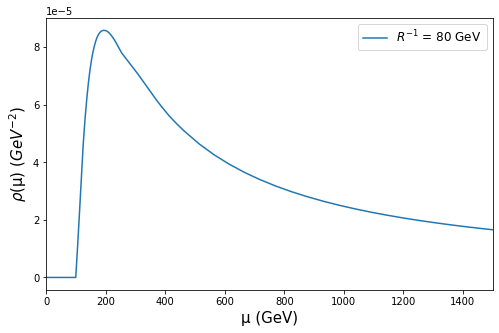

In [3]:
μs = np.linspace(0,15000,15001)

## With k = 10^10 GeV 
ϼ100R30_k1010CSV = genfromtxt('SpectralDensityCSVs/SD100R30_k1010.csv', delimiter=',')
ϼ100R80_k1010CSV = genfromtxt('SpectralDensityCSVs/SD100R80_k1010.csv', delimiter=',')
μs1, ϼ100R30_k1010 = ϼ100R30_k1010CSV[:,0], ϼ100R30_k1010CSV[:,1]
μs2, ϼ100R80_k1010 = ϼ100R80_k1010CSV[:,0], ϼ100R80_k1010CSV[:,1]

## Multiply by μ
μϼ100R30_k1010 = ϼ100R30_k1010*μs1
μϼ100R80_k1010 = ϼ100R80_k1010*μs2

## Interpolate
ϼ100R30_k1010 = interpolate.interp1d(μs1, ϼ100R30_k1010)
ϼ100R80_k1010 = interpolate.interp1d(μs2, ϼ100R80_k1010)
μϼ100R30_k1010 = interpolate.interp1d(μs1, μϼ100R30_k1010)
μϼ100R80_k1010 = interpolate.interp1d(μs2, μϼ100R80_k1010)


fig, ax = plt.subplots(1, 1, figsize = (8,5));
μs = np.linspace(0,15000,15001)
μsNEW = np.linspace(1,2499,2500)
ax.plot(μsNEW, ϼ100R80_k1010(μsNEW))
# ax.plot(μsNEW, ϼ100R30_k1010(μsNEW))
ax.legend([r'$R^{-1}$ = 80 GeV','$R^{-1}$ = 30 GeV'], fontsize=12)
ax.set_xlim(0,1500)
ax.set_xlabel('μ (GeV)', size=15)
ax.set_ylabel(r'$\rho$(μ) ($GeV^{-2}$)', size=15)
# plt.savefig('Paper/Plots/SpectralDensity_k1010_R30.png')

In [4]:
## Defining some model parameters ## 
sqrtS = 500; μ0 = 100; μϼ = μϼ100R80_k1010

# Cross Section σ

In [5]:
## Training & Unweighting for Production Cross Section  # 500,000 takes ~ 30 min
dσ_dμdμp_dict = run_MC(50000, [sqrtS, μ0, μϼ], WIC.d2σ_dμ1dμ1p, [[μ0,sqrtS-μ0], [μ0,sqrtS-μ0]])
dσ_dcosθ_dict = run_MC(50000, None,  WIC.dσ_dcosθ, [[-1,1]])

Running d2σ_dμ1dμ1p ... 
Integral, Error: 50.62351225459945 , 0.0025196354305650243
0 of 6241
5000 of 6241
shape of raw hist = (48424, 2)
shape of rescaled hist = (2191, 2)
Unweighting Efficiency = 0.045246158929456465
Running dσ_dcosθ ... 
Integral, Error: 1.3333336064798789 , 2.929432984269207e-07
0 of 6000
5000 of 6000
shape of raw hist = (46547, 1)
shape of rescaled hist = (8123, 1)
Unweighting Efficiency = 0.1745117837884289


In [6]:
# Number of Events & Integrals
print("# of (μ,μ') events: " + str(np.shape(dσ_dμdμp_dict["x Events"])))
print("# of  cosθ  events: " + str(np.shape(dσ_dcosθ_dict["x Events"])))
## Total Cross Section
print('Total Cross Section: ')
print('σ = ' + str(dσ_dμdμp_dict['Integral']*dσ_dcosθ_dict["Integral"]) + ' ab ')

# of (μ,μ') events: (2191, 2)
# of  cosθ  events: (8123, 1)
Total Cross Section: 
σ = 67.48484317881505 ab 


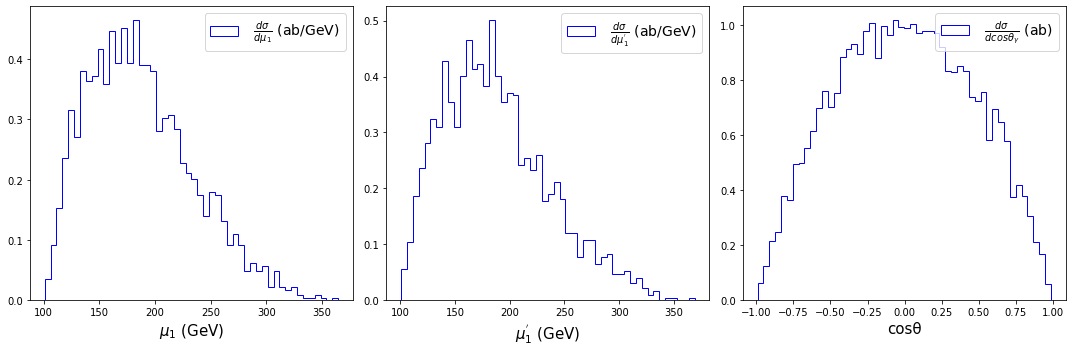

In [7]:
## Plots from PM
ProductionPlot = PM.Plotter('dσ_dμdμpdcosθ', [2,1], (15,5), 50)
ProductionPlot.addPlot([dσ_dμdμp_dict, dσ_dcosθ_dict], [['blue','blue'],['blue']], 'linear')
ProductionPlot.addFeatures([dσ_dμdμp_dict, dσ_dcosθ_dict], 
                           [r'$μ_{1}$ (GeV)',r"$μ_{1}^{'}$ (GeV)",r'cosθ'],
                      legend=True, legendlabel=[[r'$\,\,\frac{dσ}{dμ_{1}}$ (ab/GeV)'],
                                              [r"$\,\,\frac{dσ}{dμ_{1}^{'}}$ (ab/GeV)"],
                                              [r"$\,\,\frac{dσ}{dcosθ_{γ}}$ (ab)"]])
plt.tight_layout()

# Rate Γ

### 3-body Decay MC

In [8]:
## Mass Spectrum of Benchmark Model: 
## μ0 = 100 GeV | sin^2(α) = 0.1 | R^{-1} = 80 GeV | k = 10^10 GeV  
## Calculated from Mathematica: 
MassSpec = np.array([102.442,104.436,106.861,110.122,114.169,118.899,124.205,129.994,136.182,142.706,
                         149.52,156.593,163.899,171.411,179.103,186.95,194.932,203.039,211.261,219.591,
                         228.018,236.534,245.128,253.793,262.525,271.319,280.171,289.076,298.029,307.026,
                         316.062,325.135,334.242,343.381,352.551,361.748,370.971,380.217,389.483,398.77])
# Check that dm^2 ~ 2mdm
print(VMC.Δm(200, MassSpec)*2*200, VMC.Δm2(200, MassSpec))

## Profiles(R) from Mathematica
ψ2Rs = np.array([0.00378155,0.0208225,0.0447433,0.0707169,-0.101291,
                0.139188,-0.186838,0.246195,-0.318114,0.401807,-0.495047,
                -0.595291,0.700869,-0.811054,0.92505,1.04094,-1.15559,
                1.26571,-1.36914,1.46538,1.55493,-1.63826,-1.71517,-1.78499,
                -1.84726,-1.90226,-1.95101,-1.99483,2.03472,2.07113,2.10401,
                -2.13324,2.15893,-2.18156,-2.20184,2.22042,-2.23769,2.25371,-2.26839,2.28159])**2

3242.7999999999997 3226.3508969999966


In [9]:
###################################################
## Running MC for dΓ3/dμ2dx3dx4 for different μ1 ## 
###################################################
NPoints = 10000  ## 100,000 takes ~1 hour
masses = [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
          195, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 
          340, 350, 360, 370, 380, 390]
# masses = [101, 101.5, 102]
d3Γ3_ds = []
for i, μ1 in enumerate(masses):
    print('μ1: ' + str(μ1) + '  ...  ' )
    d3Γ3_ds.append(μ1)
    d3Γ3_ds.append(run_MC(NPoints, [μ1, μ0, μϼ, VMC.Δm2(μ1,MassSpec)], WIC.d3Γ3_dμ2dx3dx4, 
                          [[μ0, μ1],[0,1-(μ0/μ1)**2], [0,1-(μ0/μ1)**2]]))

μ1: 101  ...  
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 3.781922746511156e-23 , 2.0579447198359925e-24
0 of 1210
shape of raw hist = (9912, 3)
shape of rescaled hist = (61, 3)
Unweighting Efficiency = 0.0061541565778853915
μ1: 102  ...  
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 8.074820416246904e-21 , 3.067996331859861e-22
0 of 1210
shape of raw hist = (9908, 3)
shape of rescaled hist = (5, 3)
Unweighting Efficiency = 0.0005046427129592249
μ1: 103  ...  
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 1.546741573364168e-19 , 7.809378446871602e-21
0 of 1210
shape of raw hist = (9900, 3)
shape of rescaled hist = (7, 3)
Unweighting Efficiency = 0.0007070707070707071
μ1: 104  ...  
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 1.4484660284843838e-18 , 5.55053338218769e-20
0 of 1210
shape of raw hist = (9901, 3)
shape of rescaled hist = (35, 3)
Unweighting Efficiency = 0.003534996465003535
μ1: 105  ...  
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 7.807978340701815e-18 , 2.712842135240

0 of 1210
shape of raw hist = (9853, 3)
shape of rescaled hist = (43, 3)
Unweighting Efficiency = 0.004364153049832538
μ1: 380  ...  
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 0.012412883409448782 , 0.0002727338728351566
0 of 1210
shape of raw hist = (9855, 3)
shape of rescaled hist = (33, 3)
Unweighting Efficiency = 0.0033485540334855404
μ1: 390  ...  
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 0.01474262163839132 , 0.00035329844441287574
0 of 1210
shape of raw hist = (9854, 3)
shape of rescaled hist = (24, 3)
Unweighting Efficiency = 0.0024355591637913536


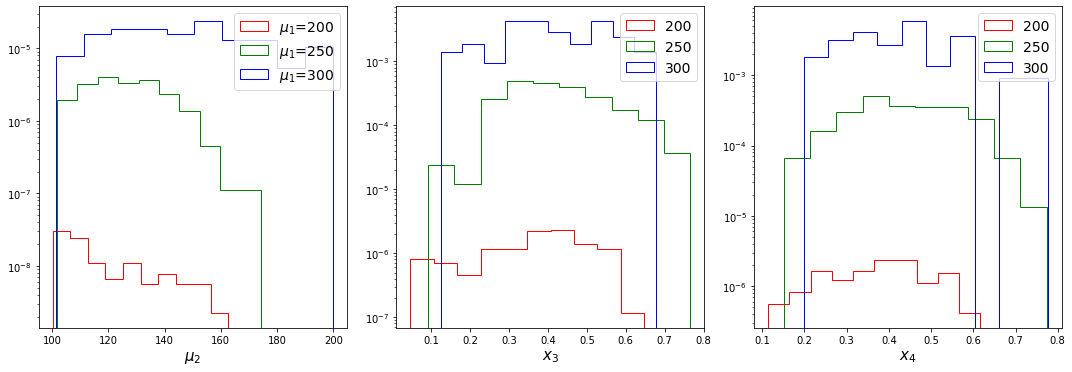

In [18]:
## Plots from PM
def IndOfM(m):  return d3Γ3_ds.index(m)+1
DecayPlot = PM.Plotter('d3Γ3_dμ2dx3dx4', [3], (15,5), 10)
DecayPlot.addPlot([d3Γ3_ds[IndOfM(200)]], [['red','red','red']], 'log')
DecayPlot.addPlot([d3Γ3_ds[IndOfM(250)]], [['green','green','green']], 'log')
DecayPlot.addPlot([d3Γ3_ds[IndOfM(300)]], [['blue','blue','blue']], 'log')

DecayPlot.addFeatures([d3Γ3_ds[IndOfM(200)]], [r'$μ_{2}$',r"$x_{3}$",r'$x_{4}$'],
                      legend=True, legendlabel=[[r'$μ_{1}$=200',r'$μ_{1}$=250',r'$μ_{1}$=300'],
                                                ['200','250','300'], ['200','250','300']] )

# Finding Threshold

In [19]:
# Compute some extra masses near the gap 
# masses = [103.5, 104.5, 105.25, 105.5, 106, 107, 108, 109, 110, 115]
masses = [106.5, 107.5]
for i, μ1 in enumerate(masses):
    d3Γ3_ds.append(μ1)
    d3Γ3_ds.append(VMC.run_MC(NPoints, [μ1, μ0, μϼ, VMC.Δm2(μ1,MassSpec)], WIC.d3Γ3_dμ2dx3dx4, 
                              [[μ0, μ1],[0,1-(μ0/μ1)**2], [0,1-(μ0/μ1)**2]]))

Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 7.287556974612836e-17 , 2.605868516565387e-18
0 of 1210
shape of raw hist = (9892, 3)
shape of rescaled hist = (7, 3)
Unweighting Efficiency = 0.0007076425394257986
Running d3Γ3_dμ2dx3dx4 ... 
Integral, Error: 2.647535288935507e-16 , 1.302763129471851e-17
0 of 1210
shape of raw hist = (9891, 3)
shape of rescaled hist = (102, 3)
Unweighting Efficiency = 0.010312405216863815


In [21]:
###############
# Decay Rates #
###############
masses = [101,102,103,104,105,106,106.5,107,107.5,108,109,110,
          120, 180, 200, 210, 220, 230, 240, 370, 390]

Γ3 = []
for i in range(len(masses)):
    Γ3.append(d3Γ3_ds[IndOfM(masses[i])]['Integral'])
Γ3_dict = dict(zip(masses,Γ3))

print('Decay Rates')
for key, value in Γ3_dict.items():
    mass_key = key
    Γ3_value = value
    print("{:<10} {:<10}".format(mass_key, Γ3_value))

#################
# Decay Lengths #
#################
print('')
avg_v = 0.65 ## from analysis code, (calculated in hindsight)
def γ(v): return 1/np.sqrt(1-v**2)
c = 3 * 10**8                    ## m/s
hbar = 6.58*10**(-16)*10**(-9)   ## GeV*s
L = avg_v*γ(avg_v)*hbar*c/np.array(Γ3)
L_dict = dict(zip(masses,L))


print('Decay Lengths')
for key, value in L_dict.items():
    mass_key = key
    L_value = value
    print("{:<10} {:<10}".format(mass_key, L_value))

Decay Rates
101        4.752149632949909e-23
102        3.086495166301267e-20
103        2.361796589596646e-19
104        1.4828480464885336e-18
105        1.2459489212987537e-17
106        5.716171681988194e-17
106.5      8.424945203651164e-17
107        1.6016111901651759e-16
107.5      2.441116847231372e-16
108        3.784438252648701e-16
109        1.2318419825633666e-15
110        3.0850739830382208e-15
120        8.887414022166378e-13
180        7.235118430989967e-08
200        6.864620309198809e-07
210        3.1076277579260377e-06
220        1.0969086479039647e-05
230        3.068399682901567e-05
240        7.272281148990784e-05
370        0.009684901595998632
390        0.015376557785103342

Decay Lengths
101        3552993.4240678754
102        5470.397809270226
103        714.8946048288244
104        113.86437360214141
105        13.551403358058739
106        2.9537874884445197
106.5      2.0040909451541986
107        1.0542106910676798
107.5      0.6916652275456306
108    

# Defining Γ3 Interpolation Function  ( used in sampling ) 

/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_75634/1074095108.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,10**(-10))


(4.4811724379296404e-24, 1e-10)

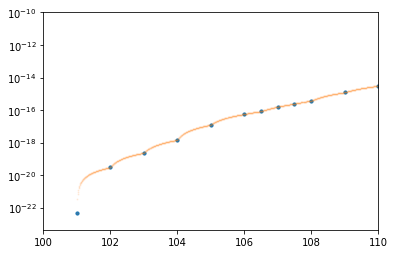

In [22]:
## 3-body Rate Interpolation 
RateArray = []
masspoints = [101,102,103,104,105,106,106.5,107,107.5,108,109,110,120,130,140,150,160,170,180,190,
              195,200,210,220,230,240,250,260,270,280,290,
              300,310,320,330,340,350,360,370,380,390]
for m in masspoints:
#     RateArray.append(eval('d3Γ3_dμ2dx3dx4_μ1_' + str(m) + '_dict')['Integral'])
    RateArray.append(d3Γ3_ds[IndOfM(m)]['Integral'])
Γ3_interp = sp.interpolate.interp1d(masspoints, RateArray, kind='linear')
plt.scatter(masspoints, RateArray, s=10)
ms = np.arange(101,390,1/100)
plt.scatter(ms, Γ3_interp(ms), s=1, alpha=0.1)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(100,110)
plt.ylim(0,10**(-10))

# Sampling, Rescaling, & Kinematics

In [23]:
#######################################################
##################  Production & Decay   ##############
##################     conversion to     ##############
##################       4-vectors       ##############
##################   ( in LHE format )   ##############
#######################################################
MC_Events_LHE = []

def sample(μ1, μ1_actual, prime, n, temp_event, threshold):
    μ2x3x4_Γ3_hist = d3Γ3_ds[IndOfM(μ1)]['x Events']
    FinalState3body_FVs(μ1, μ1_actual, prime, n, temp_event, threshold, Γ3_interp, μ2x3x4_Γ3_hist)

###############################
## When to stop the cascade ## 
threshold = 106
##############################
μ1_histo  = np.transpose(dσ_dμdμp_dict['x Events'])[0]
μ1p_histo = np.transpose(dσ_dμdμp_dict['x Events'])[1]
cosθ_histo = np.transpose(dσ_dcosθ_dict['x Events'])[0]


for i in range(len(μ1_histo)):
    temp_event = []
#------------------------------------------------------------------------------------#
#                                       Production                                   #
#------------------------------------------------------------------------------------#
######################################### μ1 #########################################
    μ1_sample   = μ1_histo[i]
    μ1p_sample  = μ1p_histo[i]
    cosθ_sample = np.arccos(np.random.choice(cosθ_histo))
#     cosθ_sample = np.arccos(cosθ_histo[i])
    ProductionFVs(μ1_sample, μ1p_sample, cosθ_sample, temp_event, False, threshold, Γ3_int=Γ3_interp, s=500**2)

#------------------------------------------------------------------------------------#
#                                         Decay                                      #
#------------------------------------------------------------------------------------#
#################################### μ2, f2a, f2b ####################################
    n = 0
    while True:
        n = n + 1
        ## get the mass 
        if n == 1:                 ### mass of 1st step 
            mass = μ1_sample  
        if n != 1:                 ### mass of nth step
#             print(n)
            particle_number = 1 + (3*n - 6)  ## for n=2, PID2 is after PID1. for n>2, PIDn is 4 after PID(n-1).
#             print('particle number: ' + str(particle_number))
#             print(temp_event)
            mass = float(np.array(temp_event)[particle_number,2])
        if mass < threshold: 
            break
        else:  
            if    101  < mass < 102:   sample(101, mass, False, n, temp_event, threshold)
            elif  102  < mass < 103:   sample(102, mass, False, n, temp_event, threshold)
            elif  103  < mass < 104:   sample(103, mass, False, n, temp_event, threshold)
            elif  104  < mass < 105:   sample(104, mass, False, n, temp_event, threshold)
            elif  105  < mass < 106:   sample(105, mass, False, n, temp_event, threshold)
            elif  106  < mass < 106.5: sample(106, mass, False, n, temp_event, threshold)
            elif  106.5  < mass < 107: sample(106.5, mass, False, n, temp_event, threshold)
            elif  107  < mass < 107.5: sample(107, mass, False, n, temp_event, threshold)
            elif  107.5  < mass < 108: sample(107.5, mass, False, n, temp_event, threshold)
            elif  108  < mass < 109:   sample(108, mass, False, n, temp_event, threshold)
            elif  109  < mass < 110:   sample(109, mass, False, n, temp_event, threshold)
            elif  110  < mass < 120:   sample(110, mass, False, n, temp_event, threshold)
            elif  120  < mass < 130:   sample(120, mass, False, n, temp_event, threshold)
            elif  130  < mass < 140:   sample(130, mass, False, n, temp_event, threshold)
            elif  140  < mass < 150:   sample(140, mass, False, n, temp_event, threshold)
            elif  150  < mass < 160:   sample(150, mass, False, n, temp_event, threshold)
            elif  160  < mass < 170:   sample(160, mass, False, n, temp_event, threshold)
            elif  170  < mass < 180:   sample(170, mass, False, n, temp_event, threshold)
            elif  180  < mass < 190:   sample(180, mass, False, n, temp_event, threshold)
            elif  190  < mass < 195:   sample(190, mass, False, n, temp_event, threshold)
            elif  195  < mass < 200:   sample(195, mass, False, n, temp_event, threshold)
            elif  200  < mass < 210:   sample(200, mass, False, n, temp_event, threshold)
            elif  210  < mass < 220:   sample(210, mass, False, n, temp_event, threshold)
            elif  220  < mass < 230:   sample(220, mass, False, n, temp_event, threshold)
            elif  230  < mass < 240:   sample(230, mass, False, n, temp_event, threshold)
            elif  240  < mass < 250:   sample(240, mass, False, n, temp_event, threshold)
            elif  250  < mass < 260:   sample(250, mass, False, n, temp_event, threshold)
            elif  260  < mass < 270:   sample(260, mass, False, n, temp_event, threshold)
            elif  270  < mass < 280:   sample(270, mass, False, n, temp_event, threshold)
            elif  280  < mass < 290:   sample(280, mass, False, n, temp_event, threshold)
            elif  290  < mass < 300:   sample(290, mass, False, n, temp_event, threshold)
            elif  300  < mass < 310:   sample(300, mass, False, n, temp_event, threshold)
            elif  310  < mass < 320:   sample(310, mass, False, n, temp_event, threshold)
            elif  320  < mass < 330:   sample(320, mass, False, n, temp_event, threshold)
            elif  330  < mass < 340:   sample(330, mass, False, n, temp_event, threshold)
            elif  340  < mass < 350:   sample(340, mass, False, n, temp_event, threshold)
            elif  350  < mass < 360:   sample(350, mass, False, n, temp_event, threshold)
            elif  360  < mass < 370:   sample(360, mass, False, n, temp_event, threshold)
            elif  370  < mass < 380:   sample(370, mass, False, n, temp_event, threshold)
            elif  380  < mass < 390:   sample(380, mass, False, n, temp_event, threshold)
            elif  390  < mass < 400:   sample(390, mass, False, n, temp_event, threshold)
#             elif  390  < mass:   sample(390, mass, 3, False, n, temp_event, threshold)

#------------------------------------------------------------------------------------#
#                                       Production                                   #
#------------------------------------------------------------------------------------#
######################################### μ1p ########################################
    μ1_sample  = μ1_histo[i]
    μ1p_sample = μ1p_histo[i]
    cosθ_sample = np.arccos(np.random.choice(cosθ_histo)) 
#     cosθ_sample = np.arccos(cosθ_histo[i])
    ProductionFVs(μ1_sample, μ1p_sample, cosθ_sample, temp_event, True, threshold, Γ3_int=Γ3_interp, s=500**2)
    
#------------------------------------------------------------------------------------#
#                                         Decay                                      #
#------------------------------------------------------------------------------------#
################################### μ2p, f2ap, f2bp ##################################
    n = 0
    while True:
        n = n + 1
        ## get the mass
        length = len(temp_event)
        if n == 1:              ### mass of 1st step
            mass = μ1p_sample 
        if n != 1:              ### mass of nth step
            particle_number = length - 3
            mass = float(np.array(temp_event)[particle_number,2])
        if mass < threshold:
            break
        else:  
            if    101  < mass < 102:   sample(101, mass, True, n, temp_event, threshold)
            elif  102  < mass < 103:   sample(102, mass, True, n, temp_event, threshold)
            elif  103  < mass < 104:   sample(103, mass, True, n, temp_event, threshold)
            elif  104  < mass < 105:   sample(104, mass, True, n, temp_event, threshold)
            elif  105  < mass < 106:   sample(105, mass, True, n, temp_event, threshold)
            elif  106  < mass < 106.5: sample(106, mass, True, n, temp_event, threshold)
            elif  106.5  < mass < 107: sample(106.5, mass, True, n, temp_event, threshold)
            elif  107  < mass < 107.5: sample(107, mass, True, n, temp_event, threshold)
            elif  107.5  < mass < 108: sample(107.5, mass, True, n, temp_event, threshold) 
            elif  108  < mass < 109:   sample(108, mass, True, n, temp_event, threshold) 
            elif  109  < mass < 110:   sample(109, mass, True, n, temp_event, threshold) 
            elif  110  < mass < 120:   sample(110, mass, True, n, temp_event, threshold)
            elif  120  < mass < 130:   sample(120, mass, True, n, temp_event, threshold)
            elif  130  < mass < 140:   sample(130, mass, True, n, temp_event, threshold)
            elif  140  < mass < 150:   sample(140, mass, True, n, temp_event, threshold)
            elif  150  < mass < 160:   sample(150, mass, True, n, temp_event, threshold)
            elif  160  < mass < 170:   sample(160, mass, True, n, temp_event, threshold)
            elif  170  < mass < 180:   sample(170, mass, True, n, temp_event, threshold)
            elif  180  < mass < 190:   sample(180, mass, True, n, temp_event, threshold)
            elif  190  < mass < 195:   sample(190, mass, True, n, temp_event, threshold)
            elif  195  < mass < 200:   sample(195, mass, True, n, temp_event, threshold)
            elif  200  < mass < 210:   sample(200, mass, True, n, temp_event, threshold)
            elif  210  < mass < 220:   sample(210, mass, True, n, temp_event, threshold)
            elif  220  < mass < 230:   sample(220, mass, True, n, temp_event, threshold)
            elif  230  < mass < 240:   sample(230, mass, True, n, temp_event, threshold)
            elif  240  < mass < 250:   sample(240, mass, True, n, temp_event, threshold)
            elif  250  < mass < 260:   sample(250, mass, True, n, temp_event, threshold)
            elif  260  < mass < 270:   sample(260, mass, True, n, temp_event, threshold)
            elif  270  < mass < 280:   sample(270, mass, True, n, temp_event, threshold)
            elif  280  < mass < 290:   sample(280, mass, True, n, temp_event, threshold)
            elif  290  < mass < 300:   sample(290, mass, True, n, temp_event, threshold)
            elif  300  < mass < 310:   sample(300, mass, True, n, temp_event, threshold)
            elif  310  < mass < 320:   sample(310, mass, True, n, temp_event, threshold)
            elif  320  < mass < 330:   sample(320, mass, True, n, temp_event, threshold)
            elif  330  < mass < 340:   sample(330, mass, True, n, temp_event, threshold)
            elif  340  < mass < 350:   sample(340, mass, True, n, temp_event, threshold)
            elif  350  < mass < 360:   sample(350, mass, True, n, temp_event, threshold)
            elif  360  < mass < 370:   sample(360, mass, True, n, temp_event, threshold)
            elif  370  < mass < 380:   sample(370, mass, True, n, temp_event, threshold)
            elif  380  < mass < 390:   sample(380, mass, True, n, temp_event, threshold)
            elif  390  < mass < 400:   sample(390, mass, True, n, temp_event, threshold)
#             elif  390  < mass:   sample(390, mass, True, n, temp_event, threshold)
    ############ Append ###########
    MC_Events_LHE.append(temp_event)
    ###############################
print('done')
print(np.shape(MC_Events_LHE))

done
(2191,)


/Users/stevenferrante/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [24]:
## Make MyLHE file ## (not an actual LHE file, but used in VegasMC_WIC_Analysis)
ConvertToLHE.arr_to_MyLHE('MC_Events', MC_Events_LHE, [dσ_dμdμp_dict, dσ_dcosθ_dict])

In [25]:
## Make LHE file ##
ConvertToLHE.arr_to_LHE_temp('MC_Events', MC_Events_LHE, [dσ_dμdμp_dict, dσ_dcosθ_dict])